In [1]:
# file wrapper-concept.ipynb
# author Jim Smith Jan 2022
# note book to explore and illustrate the basic concept of a wrapper class

# editied Jim Sith 18-2-22 to use multiple inheritance

## Some basic examples to explore what the wrapper class could look like and be implemented

### Lets start by making some data with one disclosive case
- We'll do this by adding an example to the iris data and give it a new class to make things really obvious.
- The same risks exist for more complex data sets but _everyone knows iris_

In [2]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target


# print the max and min values in each feature to help hand-craft the disclosive point
for feature in range(4):
    print(f"feature {feature} min {np.min(X[:,feature])}, min {np.max(X[:,feature])}")

# now add a single disclosve point with features [7,2,4.5,1] and label 3
X = np.vstack([X, (7, 2.0, 4.5, 1)])
y = np.append(y, 4)

feature 0 min 4.3, min 7.9
feature 1 min 2.0, min 4.4
feature 2 min 1.0, min 6.9
feature 3 min 0.1, min 2.5


### and import some basic libraries to show our point

In [3]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

## Here's the raw version
-  note I am setting random_state=1 to make it deterministic, just so you get the same reults as me
 - the general point is not that someone always will, but that they could
 - in practice I ran 10 times not setting random state and got the same tree 4/5 times

Training set accuracy in this naive case is 1.0


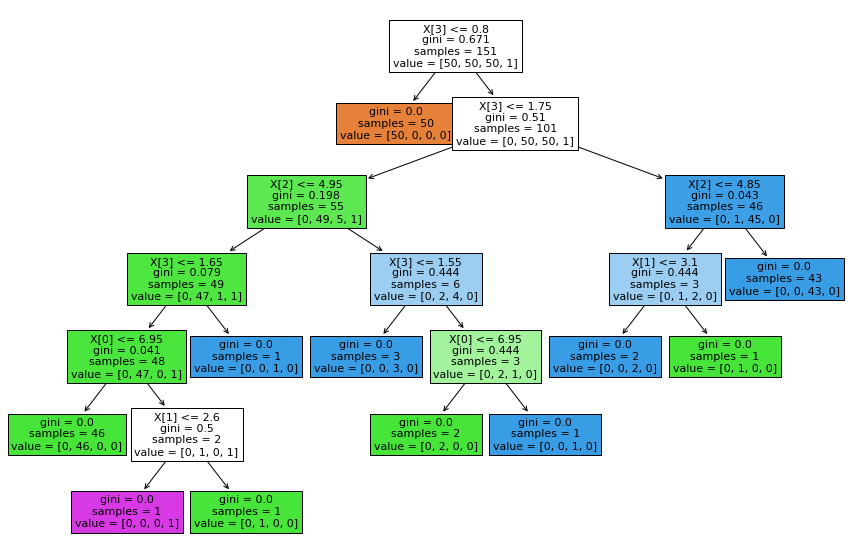

In [4]:
# example code with no safety

from sklearn.tree import DecisionTreeClassifier

rawDT = DecisionTreeClassifier(min_samples_leaf=1, criterion="gini", random_state=1)
rawDT.fit(X, y)

print(f"Training set accuracy in this naive case is {rawDT.score(X,y)}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(rawDT, filled=True, ax=ax, fontsize=11)

### As we can see we have several disclosive nodes, one of which is our added point (in purple)
The exact values cannot be inferred but if we (reasonably) assume all features are non-negative we can get uper and lower bounds for the attribute values on that node:  
> (6.95,inf),  \[0,2.6\],  (0,4.95\],  (0.8, 1.65\]

so this is disclosive to a certain degree.

- In this case I spent 5 minutes manually tuning the values of the added point so that the tree included at least one decision node for each feature

- It would be fairly trivial to use something like a Genetic Algorithm to automatically tune the feature values of the added point minimising the difference between the upper and lower bounds for each feature.

- But that is not really the point of this exercise which was to show that allowing the user to set inappropriate values for a single parameter could produce a disclosive tree. 


### Diligent user realises problem, and changes their code to enforce at least n samples in each leaf
We'll use n=5 

Training set accuracy with threshold rule enforced is 0.9668874172185431


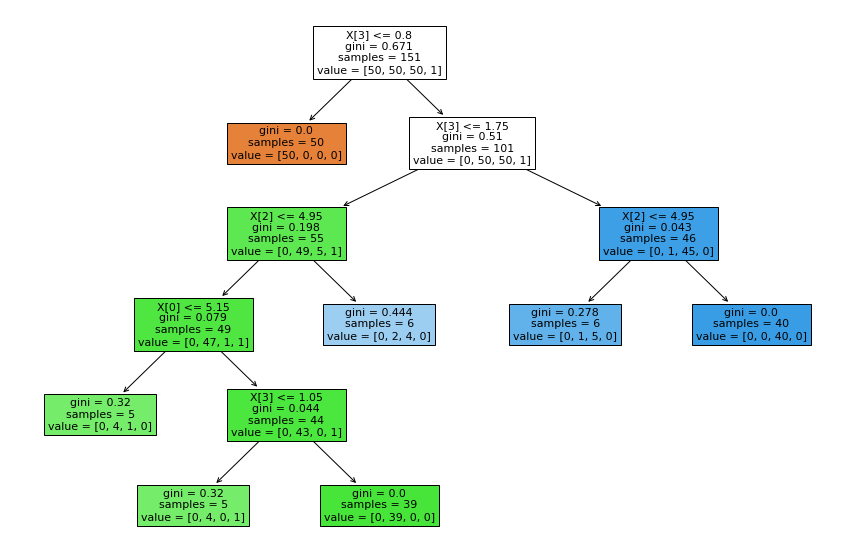

In [5]:
manualDT = DecisionTreeClassifier(min_samples_leaf=5, random_state=1)
manualDT.fit(X, y)

print(f"Training set accuracy with threshold rule enforced is {manualDT.score(X,y)}")

fig2, ax2 = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(manualDT, filled=True, ax=ax2, fontsize=11)

### output is now non-disclosive (at least according to the threshold rule)
- You can easily see we don't get a node for the new class 3

## So lets define a new class SafeDecisionTree 


In [6]:
import importlib, SafeModel

importlib.reload(SafeModel)


from SafeModel import SafeModel, SafeDecisionTree

In [7]:
noNameModel = SafeModel()

try:
    print(noNameModel.__str__())
except:
    print("super class has no attributes to print")

None with parameters: {'model_type': 'None', 'model': None, 'model_save_file': 'None', 'filename': 'None', 'researcher': 'j4-smith'}


In [8]:
safeDTModel = SafeDecisionTree()  # (criterion="entropy")
print(safeDTModel.__str__())

- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

DecisionTreeClassifier with parameters: {'model_type': 'DecisionTreeClassifier', 'model': None, 'model_save_file': 'None', 'filename': 'None', 'researcher': 'j4-smith', 'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': None, 'random_state': None, 'min_impurity_decrease': 0.0, 'class_weight': None, 'ccp_alpha': 0.0}


Training set accuracy in this naive case is 0.9668874172185431


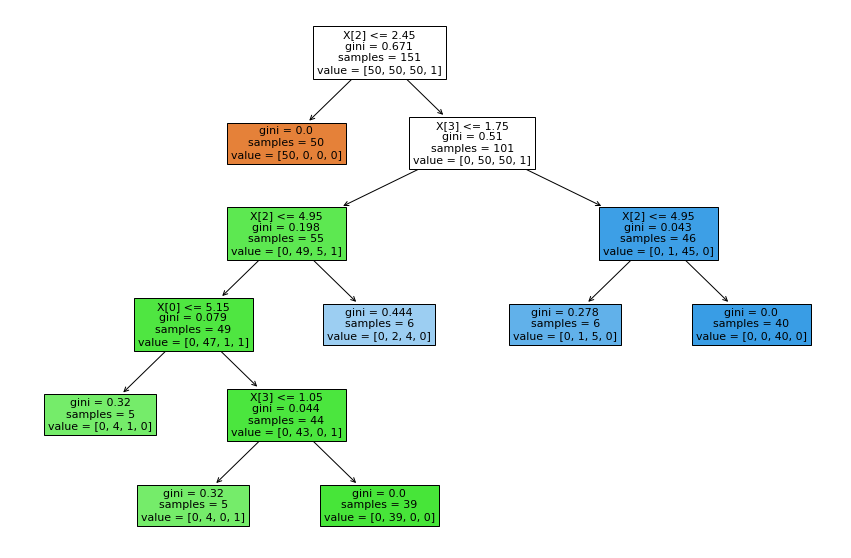

In [9]:
safeDTModel.fit(X, y)

print(f"Training set accuracy in this naive case is {safeDTModel.score(X,y)}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# output = plot_tree(safeDTModel.model,filled=True, ax=ax,fontsize=11)

output = plot_tree(safeDTModel, filled=True, ax=ax, fontsize=11)

## Now demonstrate the save and reporting functionality

In [10]:
safeDTModel.save(name="testSave.pkl")
safeDTModel.preliminary_check()
safeDTModel.request_release("testSave.pkl")

Model parameters are within recommended ranges.



## Now lets try to attack this approach
### starting with listing the params then trying to set the params manually after init

In [11]:
print(safeDTModel.__dict__)

{'model_type': 'DecisionTreeClassifier', 'model': None, 'model_save_file': 'testSave.pkl', 'filename': 'None', 'researcher': 'j4-smith', 'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': None, 'random_state': None, 'min_impurity_decrease': 0.0, 'class_weight': None, 'ccp_alpha': 0.0, 'n_features_in_': 4, 'n_outputs_': 1, 'classes_': array([0, 1, 2, 4]), 'n_classes_': 4, 'max_features_': 4, 'tree_': <sklearn.tree._tree.Tree object at 0x16418db90>}


Training set accuracy in this naive case is 1.0


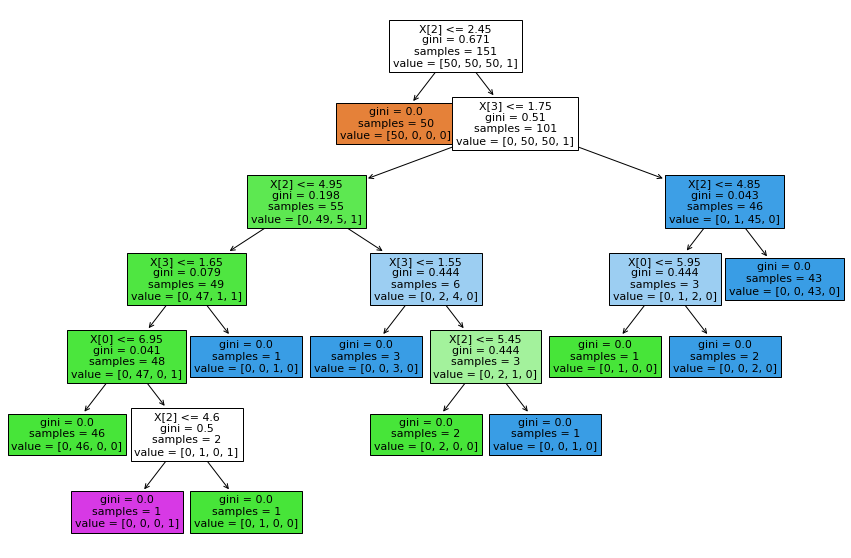

In [12]:
safeDTModel.min_samples_leaf = 1

safeDTModel.fit(X, y)

print(f"Training set accuracy in this naive case is {safeDTModel.score(X,y)}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(safeDTModel, filled=True, ax=ax, fontsize=11)

### This has let the user reset the params so that the model is now disclosive once again.

## Question: what do we do here:
1. Find a way of obfuscating the params so that they cannot be changed from outside the wrapper class
  - hard, not very python esque
  - also what if the use wants to increase min_samples_leaf which would make the model less disclosive than the default values?
2. Put code into various method within the main class that checks the param values and says if they have been changed.
 - constraints are  stored the "safe" param values in a read-only file  
   and reads that into a dict in the init() and preliminaryCheck() and requestRelease() methods. 
    - The dict key is name of parameter name, value is a tuple of [operator, value]  
      where operator is one of ["min" |"equals" | "max"] and value is applied to operator
    - the dict is read afresh in __init__() and in makeReport() to prevent users amending values 
 - this would have the benefit of allowing users to increase the min_samples_leaf but report when it was taken below our threshold
 
 - issue is how to deal with situations where the safety is built from a non-linear interaction between param values
   - that is a problem to deal with in the second stage of the project once we have proved the concept
 

In [13]:
# create and fit using recomended params
print("***researcher doesn't change recomended params")
safeDTModel2 = SafeDecisionTree()
safeDTModel2.fit(X, y)
safeDTModel2.save(name="safe2.pkl")
safeDTModel2.preliminary_check()
safeDTModel2.request_release(filename="safe2.pkl")


# change model params to recommended values
print("\n***researcher changes params safely")
safeDTModel3 = SafeDecisionTree()
safeDTModel3.min_samples_leaf = 5
safeDTModel3.fit(X, y)
safeDTModel3.save(name="safe3.pkl")
safeDTModel3.preliminary_check()
safeDTModel3.request_release(filename="safe3.pkl")


# change model params in a safe way
print("\n***researcher changes params safely")
safeDTModel4 = SafeDecisionTree()
safeDTModel4.min_samples_leaf = 10
safeDTModel4.fit(X, y)
safeDTModel4.save(name="safe4.pkl")
safeDTModel4.preliminary_check()
safeDTModel4.request_release(filename="safe4.pkl")


# change model params in an  unsafe way
print("\n***researcher changes params unsafely")
safeDTModel5 = SafeDecisionTree()
safeDTModel5.min_samples_leaf = 1
safeDTModel5.save(name="unsafe.pkl")
safeDTModel5.preliminary_check()
safeDTModel5.request_release(filename="unsafe.pkl")


# ask for a model with unsafe param values
print("\n***researcher asks for a safe_decision tree but supplies with unsafe params")
safeDTModel6 = SafeDecisionTree(min_samples_leaf=1)
safeDTModel6.fit(X, y)
safeDTModel6.save(name="fixed-unsafe.pkl")
safeDTModel6.preliminary_check()
safeDTModel6.request_release(filename="fixed-unsafe.pkl")

***researcher doesn't change recomended params
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Model parameters are within recommended ranges.


***researcher changes params safely
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Model parameters are within recommended ranges.


***researcher changes params safely
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Model parameters are within recommended ranges.


***researcher changes params unsafely
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.

***researcher asks for a safe_decision tree but supplies with unsafe params
- param

In [14]:
!echo "contents of checkfile are"; cat *_checkfile.json

contents of checkfile are
{
    "researcher": "j4-smith",
    "model_type": "DecisionTreeClassifier",
    "model_save_file": "testSave.pkl",
    "details": "Model parameters are within recommended ranges.\n",
    "recommendation": "Run file testSave.pkl through next step of checking procedure"
}{
    "researcher": "j4-smith",
    "model_type": "DecisionTreeClassifier",
    "model_save_file": "safe2.pkl",
    "details": "Model parameters are within recommended ranges.\n",
    "recommendation": "Run file safe2.pkl through next step of checking procedure"
}{
    "researcher": "j4-smith",
    "model_type": "DecisionTreeClassifier",
    "model_save_file": "safe3.pkl",
    "details": "Model parameters are within recommended ranges.\n",
    "recommendation": "Run file safe3.pkl through next step of checking procedure"
}{
    "researcher": "j4-smith",
    "model_type": "DecisionTreeClassifier",
    "model_save_file": "safe4.pkl",
    "details": "Model parameters are within recommended ranges.\